# TDE02 - Séries Temporais Redes Neurais Recorrentes
## RNN - Recurrent Neural Networks

## Modelo
No TDE02 usaremos as redes neurais recorrentes para fazer a previsão de dados de desempenho utilizando redes neurais recorrentes com o seguinte mdelo:
* Primeira camada: `Lambda` (formata a entrada para a segunda camada)
* Segunda e terceira camadas: `simpleRNN`
* Quarta camada: `Dense`
* Quarta camada: `Lambda` (formata a saída da rede)
* Função perda de `Huber` (treinamento)

## Importar bibliotecas

In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Conectar com google Drive

## Funções

### Cálcular de métricas de previsão

In [5]:
# Métricas de previsão
def metricas(previsto, observado):
    erro = previsto - observado                   # erro
    me = np.mean(erro)                            # ME
    mse = np.square(erro).mean()                  # MSE
    rmse = np.sqrt(mse)                           # RMSE
    mae = np.abs(erro).mean()                     # MAE
    mpe = (erro / observado).mean()               # MPE
    mape = np.abs(erro / observado).mean()        # MAPE
    mins = np.amin(np.hstack([previsto[:,None],
                              observado[:,None]]), axis=1)
    maxs = np.amax(np.hstack([previsto[:,None],
                              observado[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)               # MINMAX
    return({'ME':me, 'MSE':mse, 'RMSE':rmse,
            'MAE': mae, 'MPE': mpe, 'MAPE':mape,
            'MIN-MAX':minmax})

### Plotar séries

In [6]:
### Plotar séries temporais
def plotar_series(tempo, series, format="-", inicio=0, fim=None):

    # Dimensões da figura
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        for series_num in series:
            # Plotar valores x tempo
            plt.plot(tempo[inicio:fim], series_num[inicio:fim], format)
    else:
        # Plotar valores x tempo
        plt.plot(tempo[inicio:fim], series[inicio:fim], format)

    # Rótulo do eixo x
    plt.xlabel("Tempo")

    # Rótulo do eixo y
    plt.ylabel("Valor")

    # Plotar grid
    plt.grid(True)

    # Mostrar a gráfico
    plt.show()

### Função para janelamento e lotes

In [7]:
def janelamento_lotes(serie, tam_janela, tam_lote, buffer_embaralhamento):
     # Cria um dataset TF Dataset a partir dos valores da serie
    dataset = tf.data.Dataset.from_tensor_slices(serie)

    # Janelamento dos dados
    dataset = dataset.window(tam_janela + 1, shift=1, drop_remainder=True)

    # Ajustar as janelas (flatten) colocando seus elementos em lotes
    dataset = dataset.flat_map(lambda window: window.batch(tam_janela + 1))

    # Criar tuplas com variáveis (features) e rótulos (labels)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Embaralhar janelas
    dataset = dataset.shuffle(buffer_embaralhamento)

    # Criar lotes de treinamento
    dataset = dataset.batch(tam_lote).prefetch(1)

    return dataset

## Preparar dados
* Carregar os valores da série temporal do arquivo **serie_sintetica_D.csv**
* Gerar os valores de tempo
* Plotar a série

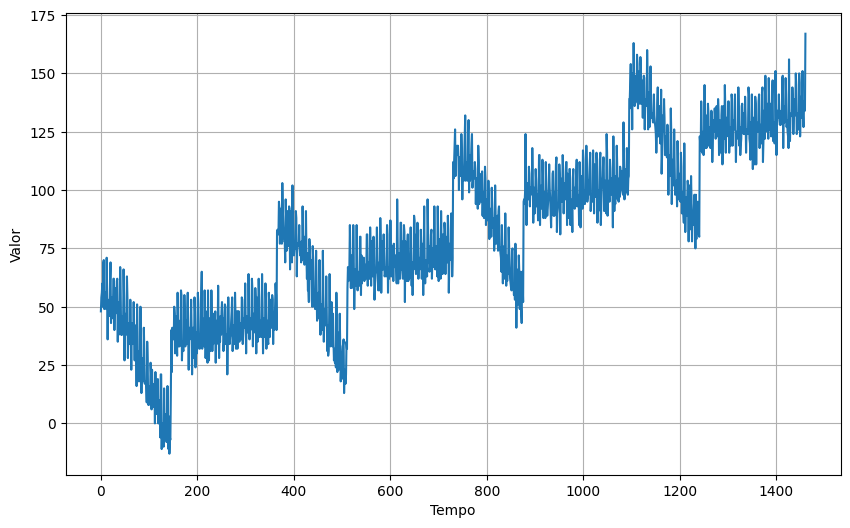

In [8]:
# Ler os dados
serie = np.loadtxt("/content/serie_sintetica_D.csv", delimiter=",", dtype="float32")
# Criar array com o tempo
tempo = np.arange(len(serie), dtype="float32")
# Plotar série
plotar_series(tempo, serie)

## Dividir os dados

In [9]:
# Definir o tamanho do conjunto de treinamento
tam_trein = 1000

# Conjunto de treinamento
tempo_trein = tempo[:tam_trein]
x_trein = serie[:tam_trein]

# Conjunto de validação
tempo_valid = tempo[tam_trein:]
x_valid = serie[tam_trein:]

## Preparar dataset para treinamento

### Parâmetros

In [10]:
# Parameteros
tam_janela = 20
tam_lote = 32
tam_buffer_embaralhamento = 1000

### Criar o dataset

In [11]:
# Criar o dataset de treinamento
dataset = janelamento_lotes(x_trein, tam_janela, tam_lote, tam_buffer_embaralhamento)

### Imprimir formato de variáveis (features) e rótulos (labels)

In [12]:
# Imprimir formato de variáveis e rótulos
for janela in dataset.take(1):
  print(f'Formato das variáveis: {janela[0].shape}')
  print(f'Formato dos rótulos: {janela[1].shape}')

Formato das variáveis: (32, 20)
Formato dos rótulos: (32,)


## Construir o modelo

### Modelo
Modelo sequencial composto por 5 camadas:<br>

Primeira camada do tipo lambda função [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda). Transforma a entrada para um tensor tridimensional no formato [tamanho do lote, intervalos de tempo, features], conforme exigido pela camada SimpleRNN (ver [documentação](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments)). A função `Lambda` remodela o formato do dataset de [tam_janela, tam_lote] para [tam_janela, tam_lote, 1], adicionando uma dimensão no último eixo da entrada. A quantidade de pontos de dados na janela (tam_janela) são mapeados para a mesma quantidade de intervalos de tempo da RNN ao definir o parâmetro `input_shape` igual ao tamanho da janela (`tam_janela`).<br>

Segunda e a terceira camadas do tipo [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN). O primeiro argumento para camadas `SimpleRNN` é um inteiro positivo com a dimensionalidade da saída, que deve ser múltiplo do tamanho da janela. A segunda camada deverá ter o argumento `return_sequences` definido como `True` para encaminhar sua saída de volta para a entrada da terceira camada.<br>

Quarta camada do tipo densa (`Dense`).<br>

Quinta camada do tipo função `Lambda`. Incluída para facilitar o treinamento. Configura a saída para valores próximos aos valores observados na série. Como as camadas SimpleRNN usam a função de ativação `tanh` que definem um intervalo de saída entre [-1,1] e os valores observados na série estão próximos de 100, a reformatação é usada uma camada Lambda() que multiplica o tamanho da saída por 100.

In [13]:
modelo_RNN = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[tam_janela]),
  tf.keras.layers.SimpleRNN(2*tam_janela, return_sequences=True),
  tf.keras.layers.SimpleRNN(2*tam_janela),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Imprimir sumário
modelo_RNN.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 20, 40)              │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

## Ajustar a taxa de aprendizagem

### Treinar o modelo para ajuste de taxa de aprendizagem
Definir parâmetros:
* Função LearningRateScheduler para ajuste no callback
* Algoritmo de otimização: SGD
* Função de perda: [Huber](https://en.wikipedia.org/wiki/Huber_loss) para minimizar a sensibilidade a outliers.


Treinar o modelo

In [14]:
# Função de callback para escalonamento de taxa de aprendizagem
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Definir algoritmo de otimização
optimizador = tf.keras.optimizers.SGD(momentum=0.9)

# Definir função de perda
modelo_RNN.compile(loss=tf.keras.losses.Huber(), optimizer=optimizador)

# Treinar o modelo
resultado_treinamento = modelo_RNN.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 20.5146 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.5910 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.5031 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.0856 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.3818 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.6415 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.4237 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.7274 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.0898 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.9835 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 17.0992 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/ste

### Visualizar perdas para selecionar taxa de aprendizagem

#### Plotar perda em função da taxa de aprendizagem

(1e-08, 0.001, 0.0, 50.0)

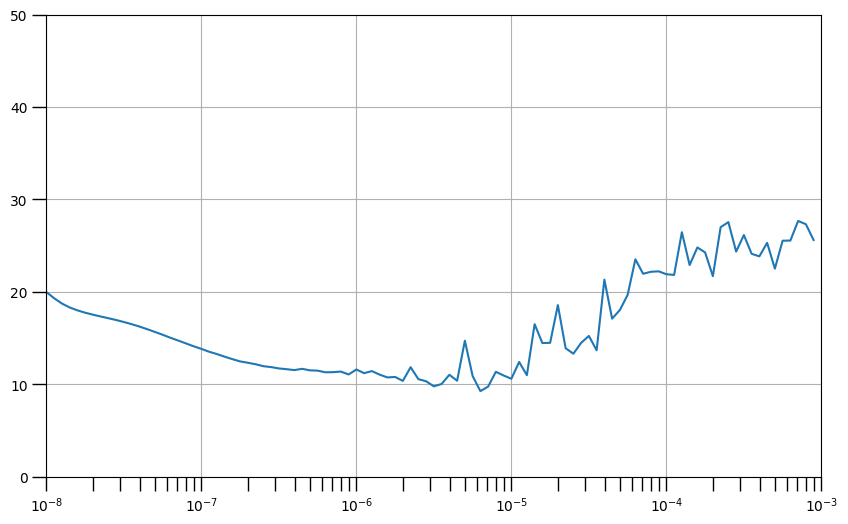

In [15]:
# Definir o array de taxas de aprendizagem
taxas_aprendizagem = 1e-8 * (10 ** (np.arange(100) / 20))

# Definir tamanho da figura
plt.figure(figsize=(10, 6))

# Definir grid
plt.grid(True)

# Plotar perda em escala logarítmica
plt.semilogx(taxas_aprendizagem, resultado_treinamento.history["loss"])

# Aumentar tamanho das marcas de ticks
plt.tick_params('both', length=10, width=1, which='both')

# Definir limites de plotagem
plt.axis([1e-8, 1e-3, 0, 50])

#### Alterar os limites do gráfico (zoom in)
Observar onde o gráfico se torna instável.

(1e-08, 0.0001, 0.0, 60.0)

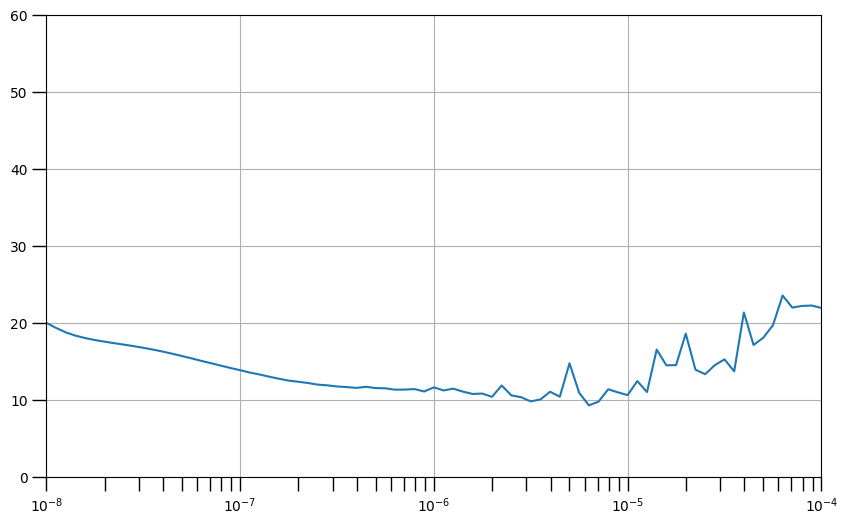

In [16]:
# Tamanho da figura
plt.figure(figsize=(10, 6))

# Definir grid
plt.grid(True)

# Plotar perda em escala logarítmica
plt.semilogx(taxas_aprendizagem, resultado_treinamento.history["loss"])

# Aumentar tamanho das marcas de ticks
plt.tick_params('both', length=10, width=1, which='both')

# Definir limites de plotagem
plt.axis([1e-8, 1e-4, 0, 60])

## Construir o modelo

In [17]:
# Construir modelo RNN
modelo_RNN = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[tam_janela]),
  tf.keras.layers.SimpleRNN(2*tam_janela, return_sequences=True),
  tf.keras.layers.SimpleRNN(2*tam_janela),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

## Treinar o modelo
Usar a taxa de aprendizagem `1e-6` (pode testar com outros valores).

In [18]:
# Definir taxa de aprendizagem
taxa_de_aprendizagem = 1e-6
#taxa_de_aprendizagem = 1e-7

# Definir algoritmo de otimização
otimizador = tf.keras.optimizers.SGD(learning_rate=taxa_de_aprendizagem, momentum=0.9)

# Definir parâmetros
modelo_RNN.compile(loss=tf.keras.losses.Huber(),
              optimizer=otimizador,
              metrics=["mae"])

# Treinar o modelo
resultado_treinamento_RNN = modelo_RNN.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 23.1926 - mae: 23.6882
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.3315 - mae: 17.8253
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.2537 - mae: 16.7486
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 15.7438 - mae: 16.2378
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 13.9522 - mae: 14.4456
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 13.5374 - mae: 14.0317
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12.7374 - mae: 13.2316
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.9055 - mae: 12.3939
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.2650 - mae: 11.7557
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11.2251 - mae: 11.7144
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.0258 - mae: 10.5121
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.5520 - mae: 10.0392
Epoc

## Previsão
O modelo é maior do que os utilizados anteriormente e a natureza sequencial das RNNs tornam as previsões mais lentas.<br>
Nas RNNs as entradas passam por uma série de etapas de tempo sequenciais, em vez do processamento paralelo.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

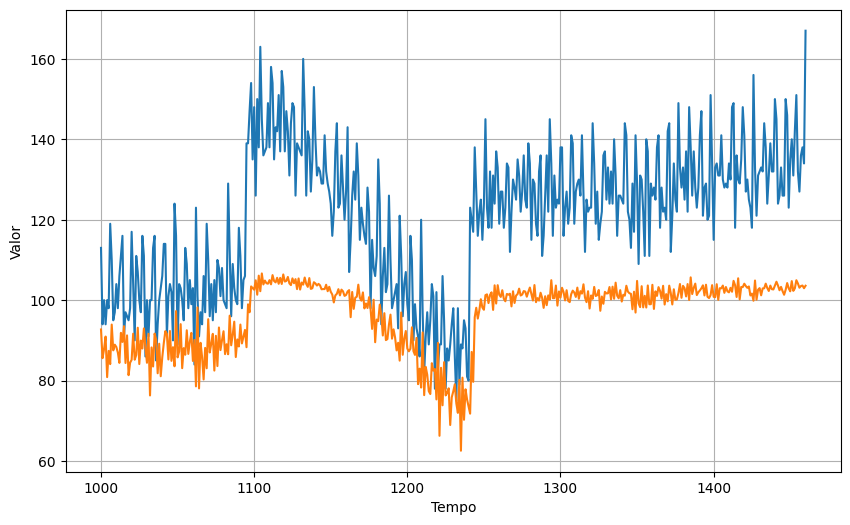

In [19]:
# Inicializar lista de previsões
forecast = []

# Selecionar pontos que estão alinhados com o conjunto de validação
serie_valid = serie[tam_trein - tam_janela:]

# Usar o modelo para prever um valor para cada janela
for indice in range(len(serie_valid) - tam_janela):
  forecast.append(modelo_RNN.predict(serie_valid[indice:indice + tam_janela][np.newaxis]))

# Converter para formato esperado pela função plotar_series
previsao = np.array(forecast).squeeze()

# Plotar as séries de validação e de previsão
plotar_series(tempo_valid, (x_valid, previsao))

## Otimizar previsão

### Criar dataset de treinamento
Inclui os mesmos passos realizados pela função `janelamento_lotes`, sem o embaralhamento de janelas.

In [20]:
# Serie de previsão
serie_forecast = serie[tam_trein - tam_janela:-1]

# Cria um dataset TF a partir dos valores da serie
dataset = tf.data.Dataset.from_tensor_slices(serie_forecast)

# Janelamento dos dados
dataset = dataset.window(tam_janela, shift=1, drop_remainder=True)

# Ajustar as janelas (flatten) colocando seus elementos em lotes
dataset = dataset.flat_map(lambda window: window.batch(tam_janela))

# Criar lotes de treinamento
dataset = dataset.batch(tam_lote).prefetch(1)

### Previsão do conjunto de validação
Diferentemente do loop utilizado na previsão do modelo preliminar que processa uma janela por vez na previsão de cada lote, a função de previsão do modelo é invocada recebendo todo o dataset.<br>
A paralelização de lotes é realizada automaticamente pelo tensorflow.*

In [21]:
forecast = modelo_RNN.predict(dataset)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


## Visualizar a previsão

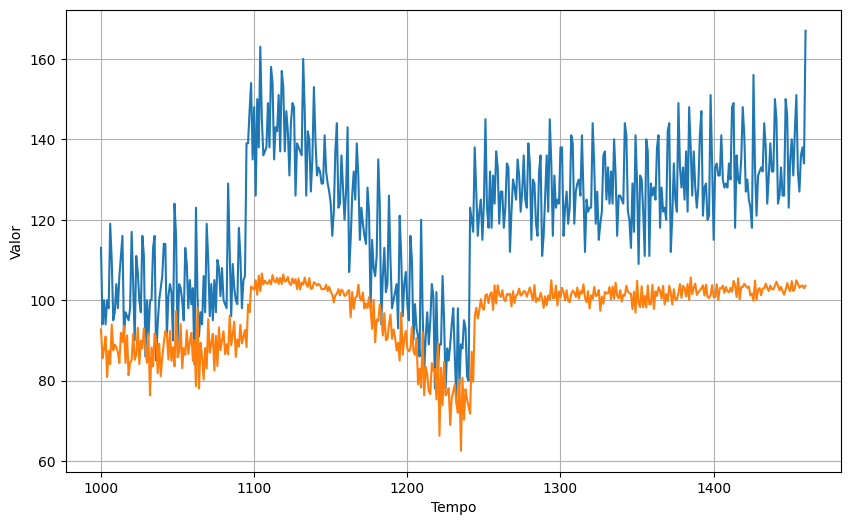

In [22]:
# Ajustar formato
previsao = forecast.squeeze()

# Plotar resultados
plotar_series(tempo_valid, (x_valid, previsao))

## Calcular MAPE

In [23]:
# Calcular MAPE
mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape = tf.keras.metrics.mse = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(x_valid, previsao)

MAPE = mape.result().numpy()/100
print(MAPE)

0.19200124740600585


# TDE02 - Comparar desempenho de modelos
Utilizar a série sintética para comparar o modelo RNN com os modelo Baseline, AUTOARIMA, GB e RN.
* Calcular e imprimir méticas do modelo ST_RNN
* Salvar as métricas no arquivo Métricas_Previsão.csv onde estão salvas as métricas de todos os modelos estudados até agora
* Plotar a métrica MAPE para os modelos: ST_Baseline, ST_AUTOARIMA, STGB, ST_RN, ST_RNN

Para realizar os passos anteriores você pode consultar o código fornecido nas avaliações formativas.
Não é necessário refazer os códigos de outros modelos porque nas avaliações formativas as métricas de desempenho foram salvas no arquivo Métricas_Previsão.csv.

## Calcular e imprimir métricas do modelo ST_RNN (valor 0,4)

In [24]:

metricas_st_rnn = metricas(previsao, x_valid)
print("Métricas do modelo ST_RNN:")
for metrica, valor in metricas_st_rnn.items():
  print(f"{metrica}: {valor}")

metricas_df = pd.DataFrame({'Modelo': ['ST_RNN'],
                          'ME': [metricas_st_rnn['ME']],
                          'MSE': [metricas_st_rnn['MSE']],
                          'RMSE': [metricas_st_rnn['RMSE']],
                          'MAE': [metricas_st_rnn['MAE']],
                          'MPE': [metricas_st_rnn['MPE']],
                          'MAPE': [metricas_st_rnn['MAPE']],
                          'MIN-MAX': [metricas_st_rnn['MIN-MAX']]})

try:
  metricas_anteriores = pd.read_csv('Métricas_Previsão.csv')
  metricas_df = pd.concat([metricas_anteriores, metricas_df], ignore_index=True)
except FileNotFoundError:
  pass

metricas_df.to_csv('Métricas_Previsão.csv', index=False)


Métricas do modelo ST_RNN:
ME: -24.150157928466797
MSE: 735.4100952148438
RMSE: 27.118446350097656
MAE: 24.289058685302734
MPE: -0.190353661775589
MAPE: 0.19200123846530914
MIN-MAX: 0.19195806980133057


## Salvar méticas para comparação (valor 0,4)

In [25]:

try:
  dfMetricas = pd.read_csv('Métricas_Previsão.csv')
except FileNotFoundError:
  dfMetricas = pd.DataFrame()

if 'ST_RNN' not in dfMetricas.columns:
  dfMetricas['ST_RNN'] = None

dfMetricas.to_csv('Métricas_Previsão.csv', index=False)

## Plotar a mética MAPE (valor 0,4)
### Modelos: ST_Baseline, ST_AUTOARIMA, ST_GB, ST_RN, ST_RNN

Modelo ST_Baseline não encontrado no arquivo 'Métricas_Previsão.csv'.
Modelo ST_AUTOARIMA não encontrado no arquivo 'Métricas_Previsão.csv'.
Modelo ST_GB não encontrado no arquivo 'Métricas_Previsão.csv'.
Modelo ST_RN não encontrado no arquivo 'Métricas_Previsão.csv'.


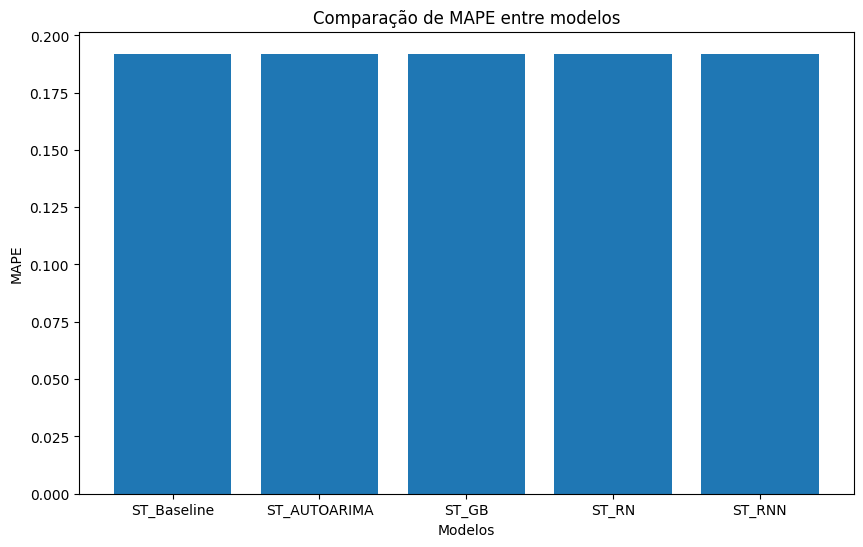

In [26]:

try:
  dfMetricas = pd.read_csv('Métricas_Previsão.csv')
except FileNotFoundError:
  print("Arquivo 'Métricas_Previsão.csv' não encontrado.")
  dfMetricas = pd.DataFrame()

if 'Modelo' in dfMetricas.columns and 'MAPE' in dfMetricas.columns:
  modelos = ['ST_Baseline', 'ST_AUTOARIMA', 'ST_GB', 'ST_RN', 'ST_RNN']
  mape_values = []
  for modelo in modelos:
    if modelo in dfMetricas['Modelo'].values:
        mape = dfMetricas.loc[dfMetricas['Modelo'] == modelo, 'MAPE'].values[0]
        mape_values.append(mape)
    else:
        print(f"Modelo {modelo} não encontrado no arquivo 'Métricas_Previsão.csv'.")

  plt.figure(figsize=(10, 6))
  plt.bar(modelos, mape_values)
  plt.xlabel('Modelos')
  plt.ylabel('MAPE')
  plt.title('Comparação de MAPE entre modelos')
  plt.show()
else:
  print("Colunas 'Modelo' ou 'MAPE' não encontradas no arquivo 'Métricas_Previsão.csv'.")

# Conclusão (valor 0,8)
## Colocar na célula abaixo a sua conclusão a respeito dos modelos de previsão de séries temporais estudados
* Baseline
* ARIMA
* Gradiete Boosting
* Redes Neurais
* Redes Neurais Recorrentes

Conclusão: ARIMA e Gradient Boosting mostraram bons resultados para capturar padrões estacionários e complexos, respectivamente. No entanto, dependem da preparação dos dados e da interpretação correta dos parâmetros.
Redes Neurais e RNNs se destacam em capturar relações não lineares e dinâmicas, especialmente em séries com padrões complexos.  Porém, podem ser mais desafiadores de treinar e otimizar, além de demandar maior poder computacional.
A escolha do modelo ideal depende de fatores como a complexidade da série temporal, a disponibilidade de dados, a necessidade de interpretabilidade e os recursos computacionais disponíveis.

Considerando os resultados do presente trabalho, pode-se observar que o modelo RNN, apesar de demandar maior poder computacional, tende a ter um desempenho superior aos demais modelos, principalmente em séries temporais mais complexas, obtendo menor MAPE. Isso é devido à sua capacidade de capturar dependências ao longo do tempo e aprender representações complexas dos dados.

Recomenda-se considerar RNNs como uma boa opção para previsão de séries temporais em cenários complexos, porém, é crucial avaliar a complexidade do problema, requisitos de tempo de processamento e recursos computacionais disponíveis antes de implementar o modelo.